# Jared Godar Regression Project

This is the overall working notebook used to acquire / prepare / clean / scale / and explore my zillo data.

The modeling and evaluation portion will be in a second notebook `zillo-modeling.ipynb`

Streamlined highlights from both notebooks can be found in the `zillo-report.ipynb` notebook.

Import libraries used in project.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np 

#Vizualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

from datetime import date



import warnings
warnings.filterwarnings("ignore")

#Custim functions
from env import host, user, password #Database credentials
import zillo_wrangle




---

## Acquire

In [2]:
# function to contact database
def get_db_url(db_name):
    return f"mysql+pymysql://{user}:{password}@{host}/{db_name}"

- Look at zillow data dictionary. 
- Import minimum features (beds, bath, tax, year, fips)
- See what other columns may prove useful in model


In [3]:
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


### Takeaways: Columns of interest that may have predictive value

- `buildingqualitytypeid` Quality 
- `fireplacecnt`
- `garagecarcnt`
- `poolcnt`
- `rawcensustractandblock`
- `censustractandblock`
- `regionidzip`
- `regionidneighborhood`
- `storytypeid`


import:
- `regionidcounty`
- 
- `

Use SQL query to get single unit (`propertylandusetypeid=261`) from May-Aug, 2017 filtering for non-zero values to have fewer nulls in the first data pull to deal with.

In [4]:
def get_data_from_sql():
    query = """
    SELECT bedroomcnt as bedrooms, 
       bathroomcnt as bathrooms,
       calculatedfinishedsquarefeet as square_feet,
       yearbuilt as year,
       taxamount as taxes,
       taxvaluedollarcnt as home_value,
       fips as fips,
       regionidzip as zip_code
    FROM predictions_2017
     JOIN properties_2017 USING(parcelid)
    WHERE (transactiondate >= '2017-01-01' AND transactiondate <= '2017-12-31') 
        AND propertylandusetypeid = '261'
        AND bedroomcnt > 0
        AND bathroomcnt > 0
        AND calculatedfinishedsquarefeet > 0 
        AND taxamount > 0
        AND taxvaluedollarcnt > 0
        AND fips > 0
    ORDER BY fips;
    """
    df = pd.read_sql(query, get_db_url('zillow'))
    return df

In [5]:
zillow = get_data_from_sql()
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,4.0,2.0,1544.0,1974.0,5419.26,430000.0,6037.0,96361.0
1,4.0,2.0,1749.0,1951.0,1432.09,96296.0,6037.0,96517.0
2,3.0,2.0,1441.0,1964.0,6194.07,469000.0,6037.0,96229.0
3,4.0,2.0,1196.0,1954.0,2140.24,113404.0,6037.0,97328.0
4,4.0,3.0,2117.0,2005.0,5635.97,253704.0,6037.0,97329.0


In [6]:
shape1 = zillow.shape
shape1

(52275, 8)

Count nulls by column

In [7]:
zillow.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52275 entries, 0 to 52274
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52275 non-null  float64
 1   bathrooms    52275 non-null  float64
 2   square_feet  52275 non-null  float64
 3   year         52242 non-null  float64
 4   taxes        52275 non-null  float64
 5   home_value   52275 non-null  float64
 6   fips         52275 non-null  float64
 7   zip_code     52252 non-null  float64
dtypes: float64(8)
memory usage: 3.2 MB


In [8]:
# get total of null values for each row
null1 = zillow.isnull().sum()
null1

bedrooms        0
bathrooms       0
square_feet     0
year           33
taxes           0
home_value      0
fips            0
zip_code       23
dtype: int64

Lots of missing neighborhood data... Drop that column before filtering NAs. (Actually removed this field from the SQL query - now not imported and not dropped)

- [ ] Drop city as well
- [ ] Figure out how to get that information from `fips`  

GO back to mysql workbench and see how many properties have the `single residential inferred` code 279

- 55614 for single family

- 0 records for inferred single family, so no need to include it in query

---

### Vizualize distribution and outliers

- Eliminating outliers may also reduce the null value counts

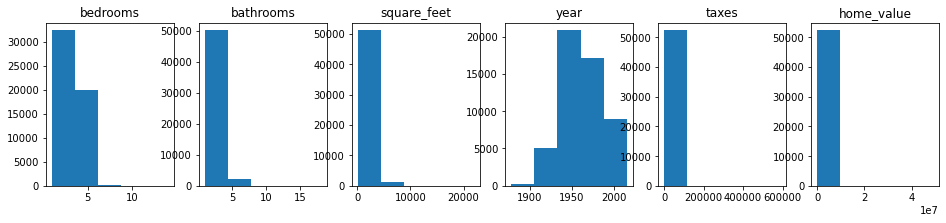

In [9]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in zillow.columns if col not in ['fips', 'year_built', 'zip_code', 'propertylandusedesc']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    zillow[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

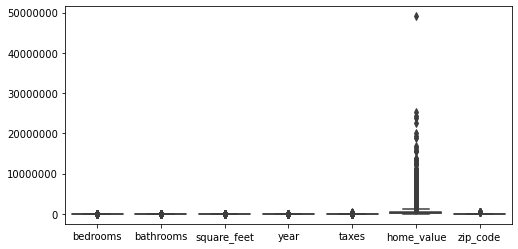

In [10]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=zillow.drop(columns=['fips']))

plt.show()

Lots of outliers - especially in value

In [11]:
zillow.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))


,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
count,52275,52275,52275,52242,52275,52275,52275,52252
mean,3.30967,2.30524,1923.5,1963.42,6435.26,528108,6049.1,96635.9
std,0.934916,1.01783,1004.07,23.118,8708.08,748325,21.0024,4612.21
min,1,1,152,1878,49.18,1000,6037,95982
25%,3,2,1268,1950,2659.39,193986,6037,96206
50%,3,2,1659,1961,4647.72,373611,6037,96412
75%,4,3,2306,1979,7371.41,618575,6059,96995
max,14,18,21929,2016,586639,4.90612e+07,6111,399675


### Remove outliers

Make remove outliers function

In [12]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [13]:
zillow.dtypes

bedrooms       float64
bathrooms      float64
square_feet    float64
year           float64
taxes          float64
home_value     float64
fips           float64
zip_code       float64
dtype: object

In [14]:
zillow = remove_outliers(zillow, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'taxes', 'home_value'])
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,4.0,2.0,1544.0,1974.0,5419.26,430000.0,6037.0,96361.0
1,4.0,2.0,1749.0,1951.0,1432.09,96296.0,6037.0,96517.0
2,3.0,2.0,1441.0,1964.0,6194.07,469000.0,6037.0,96229.0
3,4.0,2.0,1196.0,1954.0,2140.24,113404.0,6037.0,97328.0
4,4.0,3.0,2117.0,2005.0,5635.97,253704.0,6037.0,97329.0


In [15]:
shape2 = zillow.shape
print(shape1)
print(shape2)

(52275, 8)
(44953, 8)


In [16]:
removed1 = shape1[0]-shape2[0]

In [17]:
print(f'Original records: {shape1[0]}')
print(f'Records Removed: {removed1}')
print(f'Records remaining: {shape2[0]}')

Original records: 52275
Records Removed: 7322
Records remaining: 44953


In [18]:
# get total of null values for each row
null2 = zillow.isnull().sum()
print(null1)
print(null2)

bedrooms        0
bathrooms       0
square_feet     0
year           33
taxes           0
home_value      0
fips            0
zip_code       23
dtype: int64
bedrooms        0
bathrooms       0
square_feet     0
year           20
taxes           0
home_value      0
fips            0
zip_code       12
dtype: int64


Reasonable number of null values copared to total records, go ahead and drop NAs

In [19]:
# Drop NAs
zillow = zillow.dropna()

In [20]:
shape3=zillow.shape
shape3

(44922, 8)

In [21]:
removed2=shape2[0]-shape3[0]

In [22]:
print(f'Original records: {shape2[0]}')
print(f'Records Removed: {removed2}')
print(f'Records remaining: {shape3[0]}')

Original records: 44953
Records Removed: 31
Records remaining: 44922


---

### Vizualize distributions again minus outliers

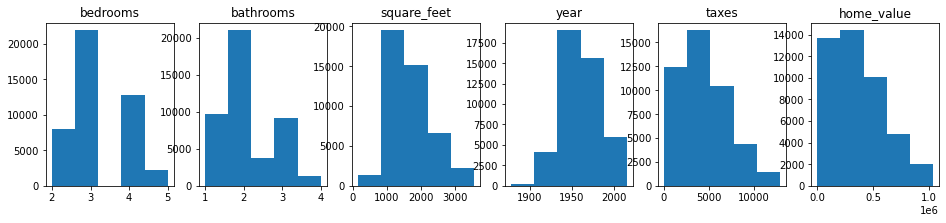

In [23]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in zillow.columns if col not in ['fips', 'zip_code', 'propertylandusedesc']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    zillow[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

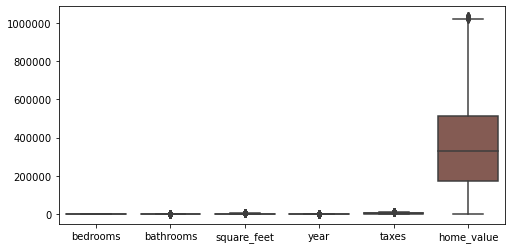

In [24]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=zillow.drop(columns=['fips', 'zip_code']))

plt.show()

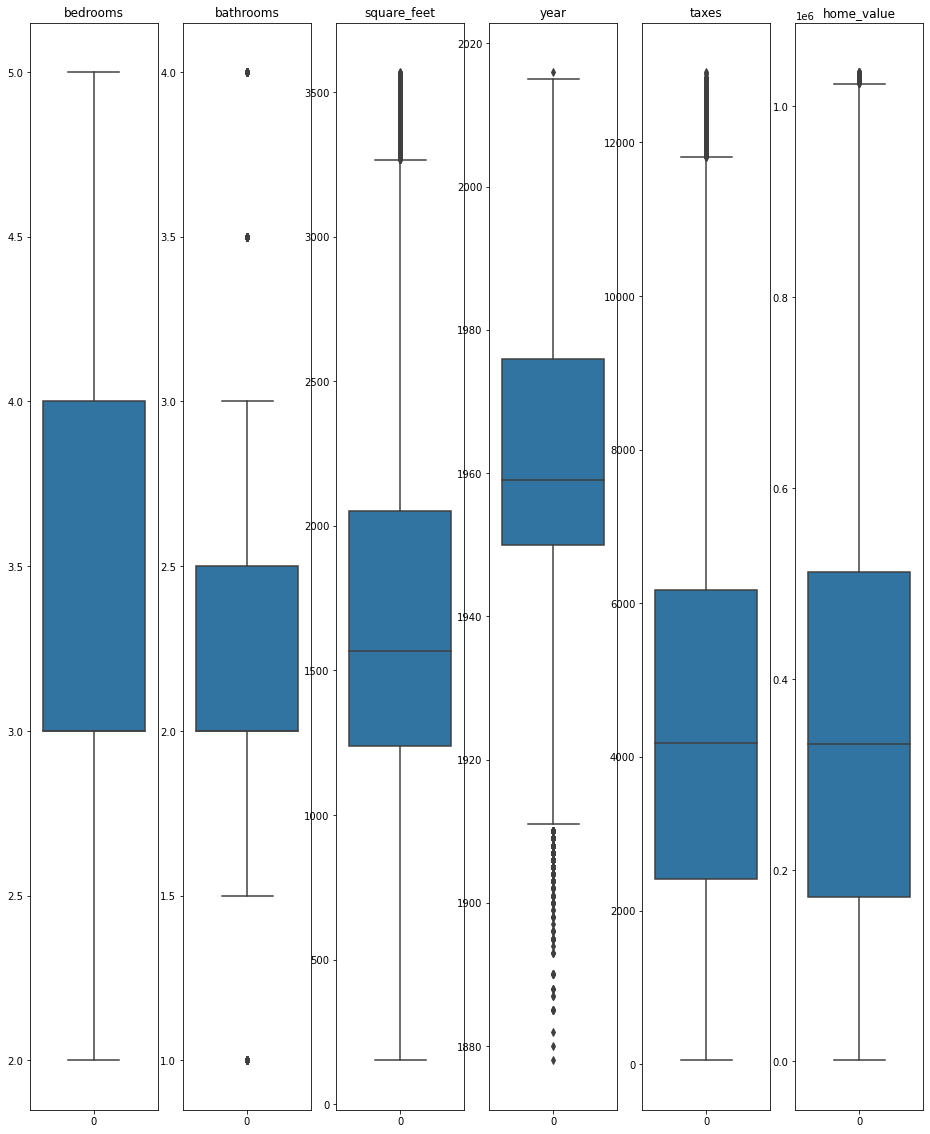

In [25]:
# List of columns
cols = [col for col in zillow.columns if col not in ['fips','zip_code', 'propertylandusedesc']]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=zillow[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

In [26]:
zillow.dtypes

bedrooms       float64
bathrooms      float64
square_feet    float64
year           float64
taxes          float64
home_value     float64
fips           float64
zip_code       float64
dtype: object

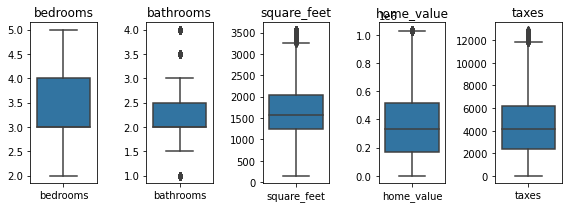

In [27]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'square_feet', 'home_value', 'taxes']

plt.figure(figsize=(8, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=zillow[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()
    
plt.show()

In [28]:
# function to clean up my zillow df
def clean_data(df):
    '''
    This funciton takes in the zillow df and drops observations with Null values
    and handles data types returning a df with a basic clean.
    '''
    df = df.dropna()
    df['fips'] = df['fips'].astype(int)
    df['zip_code'] = df['zip_code'].astype('category')
    df['square_feet'] = df['square_feet'].astype('int')
    df['year'] = df['year'].astype(int)

    return df

In [29]:
zillow.shape

(44922, 8)

In [30]:
zillow = clean_data(zillow)

In [31]:
zillow.shape

(44922, 8)

In [32]:
zillow = clean_data(zillow)
print(zillow.shape)
zillow.head()

(44922, 8)


,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,4.0,2.0,1544,1974,5419.26,430000.0,6037,96361.0
1,4.0,2.0,1749,1951,1432.09,96296.0,6037,96517.0
2,3.0,2.0,1441,1964,6194.07,469000.0,6037,96229.0
3,4.0,2.0,1196,1954,2140.24,113404.0,6037,97328.0
4,4.0,3.0,2117,2005,5635.97,253704.0,6037,97329.0


In [33]:
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,44922.0,3.207627,0.788099,2.00,3.00,3.000,4.000,5.0
bathrooms,44922.0,2.094876,0.723171,1.00,2.00,2.000,2.500,4.0
square_feet,44922.0,1693.854815,604.667105,152.00,1239.00,1568.000,2050.000,3569.0
year,44922.0,1962.004296,21.656313,1878.00,1950.00,1959.000,1976.000,2016.0
taxes,44922.0,4520.645624,2661.273572,49.18,2416.52,4187.085,6174.595,12915.8
home_value,44922.0,363835.711433,233135.067981,1000.00,171663.50,331832.500,512491.000,1035555.0
fips,44922.0,6049.076176,21.146089,6037.00,6037.00,6037.000,6059.000,6111.0


### To Do in successve iterations beyond MVP

- [ ] (for unchecked checkbox)
- [x] (for checked checkbox)


- [ ] Add column for range...
- [ ] Import additional columns of potential use
- [ ] Derive columns from there
    - Pool (boolean)
    - Condition (bins)
    - Calculate age in years
    - Bin ages
    - Etc.
- [ ] Lookup / populate county based on `fips`
- [ ] Caculate tax rate percent (`taxes`, `home_value`)


-[] Add "inferred single family residential" code to original SQL query (not necessary, 0 records)

- [x] left join on propertylandusetype



Minor, but kind of annoying find out why `[ ]` is not rendering as a checkbox in markdown in VS Code...

---

## County Data for Question

Fips codes can be found [here](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

What fips are used in dataset?

In [34]:
zillow.fips.value_counts()

6037    29295
6059    11806
6111     3821
Name: fips, dtype: int64

In [35]:
29295+11806+3821

44922

In [36]:
zillow.shape

(44922, 8)

### Fips values 

| fips |   County    | State |
| :--: | :---------: | :---: |
| 6037 | Los Angeles |  CA   |
| 6059 |   Orange    |  CA   |
| 6111 |   Ventura   |  CA   |

In [37]:
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code
0,4.0,2.0,1544,1974,5419.26,430000.0,6037,96361.0
1,4.0,2.0,1749,1951,1432.09,96296.0,6037,96517.0
2,3.0,2.0,1441,1964,6194.07,469000.0,6037,96229.0
3,4.0,2.0,1196,1954,2140.24,113404.0,6037,97328.0
4,4.0,3.0,2117,2005,5635.97,253704.0,6037,97329.0


In [38]:
zillow.dtypes

bedrooms        float64
bathrooms       float64
square_feet       int64
year              int64
taxes           float64
home_value      float64
fips              int64
zip_code       category
dtype: object

In [39]:
# Define function to add county based on fips by row

def assign_county(row):
    if row['fips']==6037:
        return 'Los Angeles'
    if row['fips']==6059:
        return 'Orange'
    if row['fips']==6111:
        return 'Ventura'

In [40]:
#Use function to assign county

zillow['county'] = zillow.apply(lambda row: assign_county(row), axis =1)

In [41]:
#Add state columns

zillow['state'] = 'CA'

In [42]:
zillow.sample(50)

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state
19182,4.0,2.0,1443,1953,10155.44,824240.0,6037,96047.0,Los Angeles,CA
15119,4.0,3.0,2609,1986,4337.86,357225.0,6037,96489.0,Los Angeles,CA
39560,5.0,3.0,2046,1970,2599.20,209610.0,6059,96965.0,Orange,CA
287,3.0,2.0,1536,1985,3173.22,212269.0,6037,96398.0,Los Angeles,CA
10220,3.0,2.0,1588,1954,5707.51,476192.0,6037,96247.0,Los Angeles,CA
20499,3.0,2.0,1633,1936,10700.59,889359.0,6037,96120.0,Los Angeles,CA
11055,3.0,1.0,1040,1923,2954.12,234319.0,6037,95984.0,Los Angeles,CA
6133,3.0,2.0,1616,1962,5680.38,440000.0,6037,96190.0,Los Angeles,CA
19148,3.0,3.0,2169,2000,7464.22,527828.0,6037,96373.0,Los Angeles,CA
20698,2.0,1.0,1090,1941,2121.87,152522.0,6037,96174.0,Los Angeles,CA


In [43]:
## COnvert year into integer (May delete or comment out later since I added this to an earlier function)

zillow['year'] = zillow['year'].astype(int)


In [44]:
# Confrim year dtype changed

zillow.dtypes

bedrooms        float64
bathrooms       float64
square_feet       int64
year              int64
taxes           float64
home_value      float64
fips              int64
zip_code       category
county           object
state            object
dtype: object

---

### Feature engineering

- Will explore more later, but any initial features?
- Transform year built to age

In [45]:
from datetime import date


In [46]:
## add age column
zillow['age'] = date.today().year-zillow.year

In [47]:
# Confirm

zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,age
0,4.0,2.0,1544,1974,5419.26,430000.0,6037,96361.0,Los Angeles,CA,47
1,4.0,2.0,1749,1951,1432.09,96296.0,6037,96517.0,Los Angeles,CA,70
2,3.0,2.0,1441,1964,6194.07,469000.0,6037,96229.0,Los Angeles,CA,57
3,4.0,2.0,1196,1954,2140.24,113404.0,6037,97328.0,Los Angeles,CA,67
4,4.0,3.0,2117,2005,5635.97,253704.0,6037,97329.0,Los Angeles,CA,16


---

## Split data into train, test, validate; Then create separate x/y feature/target dataframes


In [48]:
def split_my_data(df, pct=0.10):
    '''
    This splits a dataframe into train, validate, and test sets. 
    df = dataframe to split
    pct = size of the test set, 1/2 of size of the validate set
    Returns three dataframes (train, validate, test)
    '''
    train_validate, test = train_test_split(df, test_size=pct, random_state = 123)
    train, validate = train_test_split(train_validate, test_size=pct*2, random_state = 123)
    return train, validate, test

In [49]:
train, validate, test = split_my_data(zillow)

In [50]:
print(train.shape)
print(validate.shape)
print(test.shape)

(32343, 11)
(8086, 11)
(4493, 11)


## Baseline

- Can go ahead and add a baseline, y_hat prediction
- Will use the training median as baseline, less sensitive to outliers.

In [51]:
## Baseline

baseline = train.home_value.median()
baseline


330453.0

In [52]:
train['baseline'] = baseline
validate['baseline'] = baseline
test['baseline'] = baseline

In [53]:
train.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,age,baseline
41341,4.0,3.0,2897,1969,7103.04,707082.0,6059,96995.0,Orange,CA,52,330453.0
36463,3.0,2.0,1520,1968,7405.90,666000.0,6059,97008.0,Orange,CA,53,330453.0
42414,3.0,2.5,1551,1989,8227.20,609150.0,6059,96993.0,Orange,CA,32,330453.0
44293,4.0,3.0,2400,1987,8241.88,819623.0,6059,96987.0,Orange,CA,34,330453.0
35826,3.0,2.0,1546,1973,862.68,83402.0,6059,96995.0,Orange,CA,48,330453.0


In [54]:
# Split into x / y | features / target

# Setup X and y
X_train = train.drop(columns='home_value')
y_train = train.home_value

X_validate = validate.drop(columns='home_value')
y_validate = validate.home_value

X_test = test.drop(columns='home_value')
y_test = test.home_value

---

## Data has been aquired and cleaned, now scale

Since even our cleaned data has a fair number of outliers still, I will use the robust scaler

### Beginning exploration

- Examine pairwaise relationships
    - Crosstabs
    - Corr plots
    - Pair plots
    - Etc.

In [55]:
import sklearn.preprocessing
from sklearn.model_selection import train_test_split


In [56]:
train.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,state,age,baseline
41341,4.0,3.0,2897,1969,7103.04,707082.0,6059,96995.0,Orange,CA,52,330453.0
36463,3.0,2.0,1520,1968,7405.90,666000.0,6059,97008.0,Orange,CA,53,330453.0
42414,3.0,2.5,1551,1989,8227.20,609150.0,6059,96993.0,Orange,CA,32,330453.0
44293,4.0,3.0,2400,1987,8241.88,819623.0,6059,96987.0,Orange,CA,34,330453.0
35826,3.0,2.0,1546,1973,862.68,83402.0,6059,96995.0,Orange,CA,48,330453.0


In [57]:
train.dtypes

bedrooms        float64
bathrooms       float64
square_feet       int64
year              int64
taxes           float64
home_value      float64
fips              int64
zip_code       category
county           object
state            object
age               int64
baseline        float64
dtype: object

In [58]:
# Fit scaler to training data

scaler = sklearn.preprocessing.RobustScaler()

columns = ['bedrooms', 'bathrooms', 'square_feet', 'fips', 'age']

scaler.fit(X_train[columns])


RobustScaler()

In [59]:
# Apply scaler to all data

new_column_names = [c + '_scaled' for c in columns]

X_train = pd.concat([X_train, pd.DataFrame(scaler.transform(X_train[columns]), columns=new_column_names, index = train.index),], axis=1)

X_validate = pd.concat([X_validate, pd.DataFrame(scaler.transform(X_validate[columns]), columns=new_column_names, index = validate.index),], axis=1)

X_test = pd.concat([X_test, pd.DataFrame(scaler.transform(X_test[columns]), columns=new_column_names, index = test.index),], axis=1)



In [60]:
X_train

,bedrooms,bathrooms,square_feet,year,taxes,fips,zip_code,county,state,age,baseline,bedrooms_scaled,bathrooms_scaled,square_feet_scaled,fips_scaled,age_scaled
41341,4.0,3.0,2897,1969,7103.04,6059,96995.0,Orange,CA,52,330453.0,1.0,2.0,1.637931,1.0,-0.370370
36463,3.0,2.0,1520,1968,7405.90,6059,97008.0,Orange,CA,53,330453.0,0.0,0.0,-0.057882,1.0,-0.333333
42414,3.0,2.5,1551,1989,8227.20,6059,96993.0,Orange,CA,32,330453.0,0.0,1.0,-0.019704,1.0,-1.111111
44293,4.0,3.0,2400,1987,8241.88,6059,96987.0,Orange,CA,34,330453.0,1.0,2.0,1.025862,1.0,-1.037037
35826,3.0,2.0,1546,1973,862.68,6059,96995.0,Orange,CA,48,330453.0,0.0,0.0,-0.025862,1.0,-0.518519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27215,2.0,1.0,1416,1947,4866.42,6037,96265.0,Los Angeles,CA,74,330453.0,-1.0,-2.0,-0.185961,0.0,0.444444
34200,3.0,3.0,2383,1990,7923.06,6059,97078.0,Orange,CA,31,330453.0,0.0,2.0,1.004926,1.0,-1.148148
46904,2.0,2.0,1250,1973,3641.38,6059,96996.0,Orange,CA,48,330453.0,-1.0,0.0,-0.390394,1.0,-0.518519
7907,3.0,1.0,969,1965,2570.66,6037,95982.0,Los Angeles,CA,56,330453.0,0.0,-2.0,-0.736453,0.0,-0.222222


In [61]:
X_train.shape

(32343, 16)

Text(0.5, 1.0, 'Scaled')

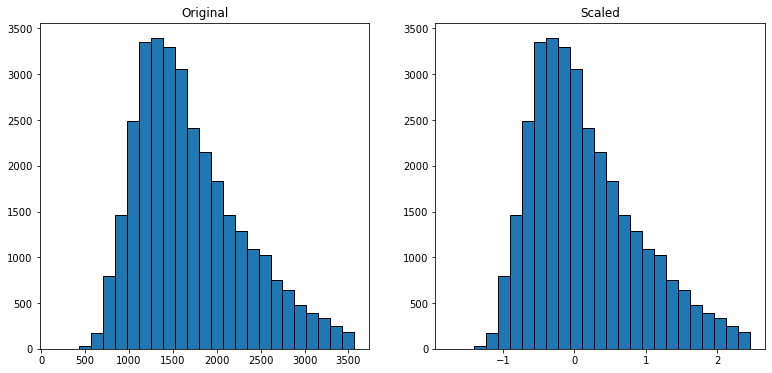

In [65]:
#Vizualize scaler

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.square_feet, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train.square_feet_scaled, bins=25, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

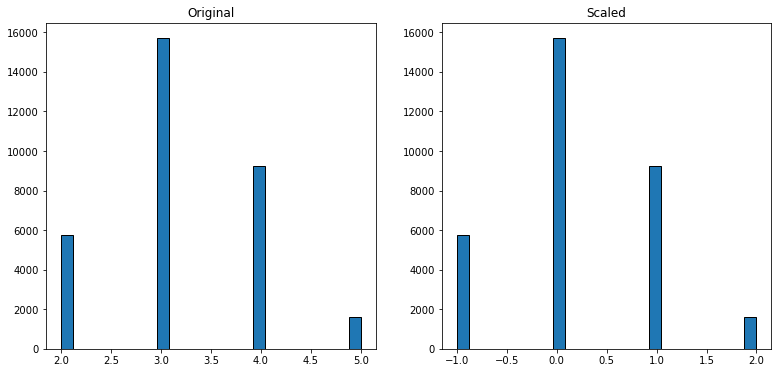

In [66]:
#Vizualize scaler

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.bedrooms, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train.bedrooms_scaled, bins=25, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

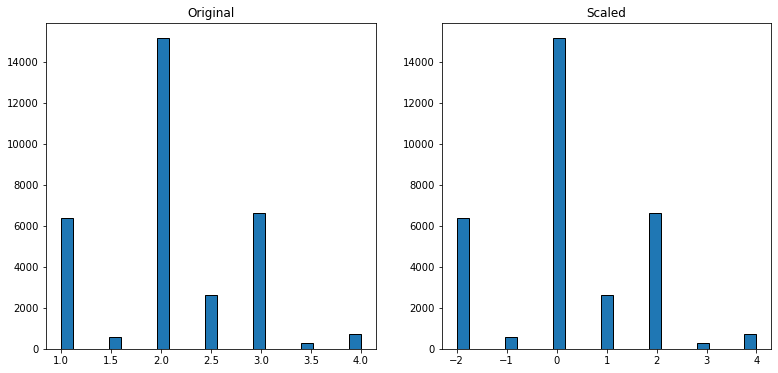

In [67]:
#Vizualize scaler

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.bathrooms, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train.bathrooms_scaled, bins=25, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

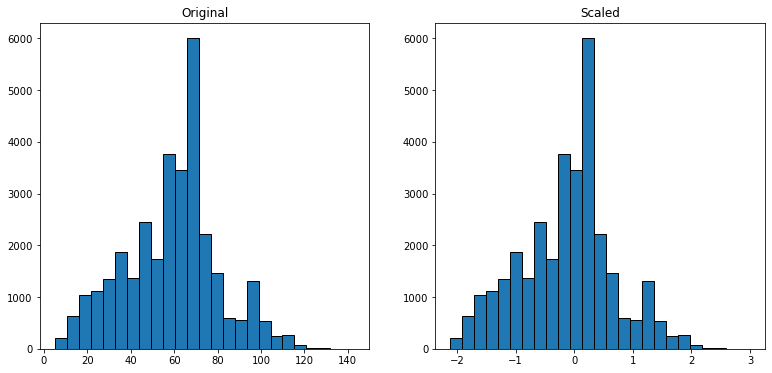

In [68]:
#Vizualize scaler

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.age, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train.age_scaled, bins=25, ec='black')
plt.title('Scaled')

In [ ]:
X_train_scaled.describe().T

___

In [ ]:
########## Combine all of the above steps into function(s)#################

#################### IMPORT LIBRARIES #################

# Basic libraries
import pandas as pd
import numpy as np 

#Vizualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

from datetime import date

import sklearn.preprocessing
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

#Custim functions
from env import host, user, password #Database credentials
import zillo_wrangle





################ PULL DATA FROM DB ############## 

def get_db_url(db_name):
    return f"mysql+pymysql://{user}:{password}@{host}/{db_name}"


def get_data_from_sql():
    query = """
    SELECT bedroomcnt as bedrooms, 
       bathroomcnt as bathrooms,
       calculatedfinishedsquarefeet as square_feet,
       yearbuilt as year,
       taxamount as taxes,
       taxvaluedollarcnt as home_value,
       fips as fips,
       regionidzip as zip_code
    FROM predictions_2017
     JOIN properties_2017 USING(parcelid)
    WHERE (transactiondate >= '2017-01-01' AND transactiondate <= '2017-12-31') 
        AND propertylandusetypeid = '261'
        AND bedroomcnt > 0
        AND bathroomcnt > 0
        AND calculatedfinishedsquarefeet > 0 
        AND taxamount > 0
        AND taxvaluedollarcnt > 0
        AND fips > 0
    ORDER BY fips;
    """
    df = pd.read_sql(query, get_db_url('zillow'))
    return df


################ REMOVE OUTLIERS #################

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

######## Clean Data ###########

def clean_data(df):
    '''
    This funciton takes in the zillow df and drops  Null values reassigns some dtypes.
    '''
    df = df.dropna()
    df['fips'] = df['fips'].astype(int)
    df['zip_code'] = df['zip_code'].astype('category')
    df['square_feet'] = df['square_feet'].astype('int')
    df['year'] = df['year'].astype(int)

    return df

######### ADD COUNTY AND STATE COLUMNS #######

def assign_county(row):
    if row['fips']==6037:
        return 'Los Angeles'
    if row['fips']==6059:
        return 'Orange'
    if row['fips']==6111:
        return 'Ventura'

######## Feature engineering ########

def engineer(zillow):
    zillow['county'] = zillow.apply(lambda row: assign_county(row), axis =1) #Add counties
    zillow['state'] = 'CA' #Add state
    zillow['age'] = date.today().year-zillow.year # Add age
    return zillow

########## TRAIN VALIDATE TEST SPLIT #########

def split_my_data(df, pct=0.10):
    '''
    This splits a dataframe into train, validate, and test sets. 
    df = dataframe to split
    pct = size of the test set, 1/2 of size of the validate set
    Returns three dataframes (train, validate, test)
    '''
    train_validate, test = train_test_split(df, test_size=pct, random_state = 123)
    train, validate = train_test_split(train_validate, test_size=pct*2, random_state = 123)
    return train, validate, test

########## ADD BASELINE #########

def add_baseline(train, validate, test):
    baseline = train.home_value.median()
    train['baseline'] = baseline
    validate['baseline'] = baseline
    test['baseline'] = baseline
    return train, validate, test

######## SPLIT IN TO X /y features / target ########

def split_xy(train, validate, test):
    X_train = train.drop(columns='home_value')
    y_train = train.home_value

    X_validate = validate.drop(columns='home_value')
    y_validate = validate.home_value

    X_test = test.drop(columns='home_value')
    y_test = test.home_value

    return X_train, y_train, X_validate, y_validate, X_test, y_test

############## Robust Scale ###############

def scale(X_train, X_validate, X_test, train, validate, test):
    scaler = sklearn.preprocessing.RobustScaler()

    columns = ['bedrooms', 'bathrooms', 'square_feet', 'fips', 'age']
    
    scaler.fit(X_train[columns])

    new_column_names = [c + '_scaled' for c in columns]

    X_train = pd.concat([X_train, pd.DataFrame(scaler.transform(X_train[columns]), columns=new_column_names, index = train.index),], axis=1)

    X_validate = pd.concat([X_validate, pd.DataFrame(scaler.transform(X_validate[columns]), columns=new_column_names, index = validate.index),], axis=1)

    X_test = pd.concat([X_test, pd.DataFrame(scaler.transform(X_test[columns]), columns=new_column_names, index = test.index),], axis=1)
    
    return X_train, X_validate, X_test

######### CALL ALL FUNCTIONS TOGETHER #######

def wrangle():
    zillow = get_data_from_sql()
    zillow = remove_outliers(zillow, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'taxes', 'home_value'])
    zillow = clean_data(zillow) #Drop NAs and change dtypes
    zillow = engineer(zillow)
    train, validate, test = split_my_data(zillow)
    train, validate, test = add_baseline(train, validate, test)
    X_train, y_train, X_validate, y_validate, X_test, y_test = split_xy(train, validate, test)
    X_train, X_validate, X_test = scale(X_train, X_validate, X_test, train, validate, test)
    return X_train, y_train, X_validate, y_validate, X_test, y_test








---

## EDA

### Initial questions:

1. What are drivers of tax value?
2. What leads to lower tax values?
3. What factors do not impact tax value?
4. Are there any ways to combine the current data into interesting engineered features?

In [70]:
X_train.sample(50)

,bedrooms,bathrooms,square_feet,year,taxes,fips,zip_code,county,state,age,baseline,bedrooms_scaled,bathrooms_scaled,square_feet_scaled,fips_scaled,age_scaled
17831,3.0,3.0,2277,1959,1804.99,6037,96355.0,Los Angeles,CA,62,330453.0,0.0,2.0,0.874384,0.000000,0.000000
23502,4.0,3.0,1776,1952,3889.59,6037,96172.0,Los Angeles,CA,69,330453.0,1.0,2.0,0.257389,0.000000,0.259259
8069,5.0,4.0,3040,2000,7046.35,6037,96398.0,Los Angeles,CA,21,330453.0,2.0,4.0,1.814039,0.000000,-1.518519
25394,2.0,1.0,1008,1925,2567.80,6037,96113.0,Los Angeles,CA,96,330453.0,-1.0,-2.0,-0.688424,0.000000,1.259259
5542,3.0,1.0,1018,1952,3830.48,6037,96159.0,Los Angeles,CA,69,330453.0,0.0,-2.0,-0.676108,0.000000,0.259259
2901,2.0,1.0,832,1920,3743.85,6037,96046.0,Los Angeles,CA,101,330453.0,-1.0,-2.0,-0.905172,0.000000,1.444444
48862,4.0,4.0,2227,1961,6292.62,6111,97116.0,Ventura,CA,60,330453.0,1.0,4.0,0.812808,3.363636,-0.074074
29859,4.0,1.0,1798,1949,5127.73,6037,96042.0,Los Angeles,CA,72,330453.0,1.0,-2.0,0.284483,0.000000,0.370370
32268,3.0,2.0,1537,1952,1048.65,6037,96242.0,Los Angeles,CA,69,330453.0,0.0,0.0,-0.036946,0.000000,0.259259
43906,4.0,2.0,1266,1955,906.62,6059,97050.0,Orange,CA,66,330453.0,1.0,0.0,-0.370690,1.000000,0.148148


---

---

# Modeling

Data is now clean split, and scaled and we have a baseline and a feel for meaningful drivers. Proceed with creating MVP model.